In [1]:
import glob
import json
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

## 前処理ネタ

1. `name` に含まれる情報はクレンジングしておきたい
1. `name` の埋め込みベクトル、文字列長さ、単語数
  - `name` の言語はほぼ日本語、英語、中国語。まれにハングルがあるが両の手にすら満たない数かも。
  - FastText の言語識別モデルの結果は信用できそう。日本語英語中国語以外は英語で処理する。ハングルは90%超えたら信用できそうだ数は少ない。
  - [このノート](notebooks/nameって何語なの？.ipynb)
1. `host_id` のエンコーディング
    1. Frequency encoding
    1. レビュー履歴を集計する
    1. Cross table 集計で持っている物件の特徴を定量化（`neighbourhood`, `room_type` あたりがよさそう）
1. 最寄り駅 Top $N$ の名前と距離
    1. 駅名の重複に注意
    1. "押上（スカイツリー前）"、押上〈スカイツリー前〉の2つが存在するので注意（経度緯度は同じなので削除）
1. 経度緯度
    1. クラスタリングしてセントロイドからの距離を測る（場所が個性的度）
    1. 自身から $N$ の距離内の駅数（利便性の尺度？）
    1. 自身から $N$ の距離内の民泊数（競争過密度？）

1. 同じ価格の民泊がたくさんありそう？調べてみる。


## やってみたいこと

|No|CV|
|---:|:---|
|1|特徴量：`neighbourhood`, `latitude`, `longitude`, `room_type`, `minimum_nights`, `number_of_reviews`, `reviews_per_month`, `availability_365`, `review_date`, CV: StratifiedKfold(`neighborhood`), モデル：CatBoost|v
|2|特徴量：2 + `name` を train と test で共有されていなければ専用の値でマスク, CV: StratifiedKfold(`neighborhood`), モデル：CatBoost|
|3|特徴量：2 + `name` を Tf-IDF+LSIで64次元のベクトルに 
|4|特徴量：2 + `name` を Tf-IDF+LDAで64次元のベクトルに 
|5|特徴量：2 + `name` を Tf-IDF+NMFで64次元のベクトルに
|6|特徴量：2 + `name` を Tf-IDF+LSIで32次元のベクトルに 
|7|特徴量：2 + `name` を Tf-IDF+LDAで32次元のベクトルに 
|8|特徴量：2 + `name` を Tf-IDF+NMFで32次元のベクトルに
|9|特徴量：2 + `name` を Tf-IDF+LSIで16次元のベクトルに 
|10|特徴量：2 + `name` を Tf-IDF+LDAで16次元のベクトルに 
|11|特徴量：2 + `name` を Tf-IDF+NMFで16次元のベクトルに
|12|No.3 の Fold を StratifiedKFold(`y`を binning したやつ)|
|13|No.3 の Fold を GroupKFold(`host_id`)|
|14|No.5 の Fold を StratifiedKFold(`y`を binning したやつ)|
|15|No.5 の Fold を GroupKFold(`host_id`)|
|16|No.6 の Fold を StratifiedKFold(`y`を binning したやつ)|
|17|No.6 の Fold を GroupKFold(`host_id`)|
|18|No.8 の Fold を StratifiedKFold(`y`を binning したやつ)|
|19|No.8 の Fold を GroupKFold(`host_id`)|

2022-04-28

No.11 まで実施するも CV vs LB の並びが気に食わない。相関は強そうだがロスに差があるのはさておき順位が一致しないのが気持ち悪い
StratifiedKFold(`neighbourhood`)以外の方法も試して信頼できる CV を探したい。No.3, 5, 6, 8 を対象に以下を試す。

- StratifiedKFold: `y`を binning して bin を層とみなす
- GroupKFold(`host_id`): [このDiscussion](https://comp.probspace.com/competitions/bnb_price/discussions/shirapon24-Postde0ee1e20bc5d402eea0) でやってる人がいる。


## CV vs LB

In [7]:
lb = [
    ('001', 0.86378),
    ('002', np.nan),  # `y` を対数変換せずに学習して Submit したので他と比べられない
    ('003', 0.82206),
    ('004', 0.85716),
    ('005', 0.80957),
    ('006', 0.82747),
    ('007', 0.84814),
    ('008', 0.82104),
    ('009', 0.83919),
    ('010', 0.86311),
    ('011', 0.83046),
]
lb = pd.DataFrame(lb, columns=['No', 'LB'])
assert not lb['No'].duplicated().any()
lb

,No,LB
0,001,0.86378
1,002,NaN
2,003,0.82206
3,004,0.85716
4,005,0.80957
5,006,0.82747
6,007,0.84814
7,008,0.82104
8,009,0.83919
9,010,0.86311


In [8]:
cv = []
for filepath in glob.glob(os.path.join('notebooks', '*', 'result.json')):
    with open(filepath, 'r') as f:
        cv.append(json.load(f))
cv = pd.DataFrame(cv)
cv

,No,CV,Fold
0,001,0.694386,NaN
1,002,0.697720,NaN
2,003,0.589649,NaN
3,004,0.667733,NaN
4,005,0.590896,NaN
5,006,0.600847,NaN
6,007,0.674444,NaN
7,008,0.604754,NaN
8,009,0.610643,NaN
9,010,0.677813,NaN


In [9]:
cv_vs_lb = pd.merge(cv, lb, how='left').set_index('No')
cv_vs_lb['Fold'].fillna('StratifiedKFold(neighbourhood)', inplace=True)
cv_vs_lb['Rank(CV)'] = cv_vs_lb['CV'].rank().astype('int')
cv_vs_lb['Rank(LB)'] = cv_vs_lb['LB'].rank()
cv_vs_lb

,CV,Fold,LB,Rank(CV),Rank(LB)
No,,,,,
001,0.694386,StratifiedKFold(neighbourhood),0.86378,14,10.0
002,0.697720,StratifiedKFold(neighbourhood),NaN,15,NaN
003,0.589649,StratifiedKFold(neighbourhood),0.82206,1,3.0
004,0.667733,StratifiedKFold(neighbourhood),0.85716,11,8.0
005,0.590896,StratifiedKFold(neighbourhood),0.80957,2,1.0
006,0.600847,StratifiedKFold(neighbourhood),0.82747,6,4.0
007,0.674444,StratifiedKFold(neighbourhood),0.84814,12,7.0
008,0.604754,StratifiedKFold(neighbourhood),0.82104,8,2.0
009,0.610643,StratifiedKFold(neighbourhood),0.83919,9,6.0


In [10]:
cv_vs_lb.sort_values('Rank(CV)')

,CV,Fold,LB,Rank(CV),Rank(LB)
No,,,,,
003,0.589649,StratifiedKFold(neighbourhood),0.82206,1,3.0
005,0.590896,StratifiedKFold(neighbourhood),0.80957,2,1.0
012,0.591465,StratifiedKFold(y_bin),NaN,3,NaN
014,0.593259,StratifiedKFold(y_bin),NaN,4,NaN
016,0.596061,StratifiedKFold(y_bin),NaN,5,NaN
006,0.600847,StratifiedKFold(neighbourhood),0.82747,6,4.0
018,0.602999,StratifiedKFold(y_bin),NaN,7,NaN
008,0.604754,StratifiedKFold(neighbourhood),0.82104,8,2.0
009,0.610643,StratifiedKFold(neighbourhood),0.83919,9,6.0


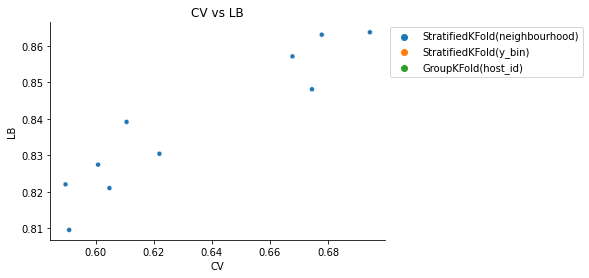

In [11]:
fig, _ = plt.subplots(nrows=1, ncols=1, sharex=True,sharey=True)
ax = sns.scatterplot(data=cv_vs_lb, x='CV', y='LB', hue='Fold', s=24)
ax.legend(loc='upper left', bbox_to_anchor=[1., 1.])
ax.set_title('CV vs LB')
sns.despine()

In [15]:
cv_vs_lb.groupby('Fold').corr()

CV        LB  Rank(CV)  \
Fold                                                                    
GroupKFold(host_id)            CV        1.000000       NaN  0.985785   
                               LB             NaN       NaN       NaN   
                               Rank(CV)  0.985785       NaN  1.000000   
                               Rank(LB)       NaN       NaN       NaN   
StratifiedKFold(neighbourhood) CV        1.000000  0.940146  0.909166   
                               LB        0.940146  1.000000  0.875600   
                               Rank(CV)  0.909166  0.875600  1.000000   
                               Rank(LB)  0.924164  0.988121  0.870388   
StratifiedKFold(y_bin)         CV        1.000000       NaN  0.991865   
                               LB             NaN       NaN       NaN   
                               Rank(CV)  0.991865       NaN  1.000000   
                               Rank(LB)       NaN       NaN       NaN   

                                         Rank(LB)  
Fold                                               
GroupKFold(host_id)            CV             NaN  
                               LB             NaN  
                               Rank(CV)       NaN  
                               Rank(LB)       NaN  
StratifiedKFold(neighbourhood) CV        0.924164  
                               LB        0.988121  
                               Rank(CV)  0.870388  
                               Rank(LB)  1.000000  
StratifiedKFold(y_bin)         CV             NaN  
                               LB             NaN  
                               Rank(CV)       NaN  
                               Rank(LB)       NaN

## Submissions

In [12]:
submissions = []
for filepath in glob.glob(os.path.join('notebooks', '*', 'submission*.csv')):
    sub = pd.read_csv(filepath).set_index('id').rename(columns={'y': os.path.basename(filepath).replace('.csv', '')})
    submissions.append(sub)
submissions = pd.concat(submissions, axis=1)
submissions

,submission_001,submission_002,submission_003,submission_004,submission_005,submission_006,submission_007,submission_008,submission_009,submission_010,submission_011,submission_012,submission_013,submission_014,submission_015,submission_016,submission_017,submission_018,submission_019
id,,,,,,,,,,,,,,,,,,,
1,15563.757288,15412.997055,15149.523135,13178.117184,11980.825061,10508.393906,15667.459837,11324.098572,12065.894615,14905.229225,12359.642436,14680.584711,13856.187267,12472.965218,11886.538068,12177.044466,11203.017316,15129.675295,13664.167528
2,11315.311473,11800.884838,16759.002170,18896.921538,17543.344321,18547.891042,15522.055171,19381.293858,13768.671233,13016.722028,15491.592679,16827.877970,15642.081178,17618.680222,16695.584957,12898.805566,14266.701536,14918.934304,17273.181794
3,15921.739860,15458.861373,12868.850477,13833.183047,8661.947943,14978.764058,14609.431020,12749.191746,14776.633311,13855.485504,14029.558956,13876.138395,13306.320633,8934.872804,8391.386761,13767.248435,14372.625915,11188.267416,9492.355749
4,18301.790676,17935.568540,18215.072414,18200.361440,13063.205844,17165.856038,13294.381434,11831.085654,13983.897808,16297.975643,9608.618615,16627.634698,15826.728249,12407.409390,13007.335344,19104.682752,20938.128847,14421.957374,13259.487013
5,16902.712775,17462.485144,13713.515681,10807.210259,17727.311670,16046.239749,10672.610902,19578.740872,13694.180372,12693.326009,16749.748241,13972.478137,16000.549017,16957.168420,17812.238169,14156.979671,14275.250233,14545.253738,14740.084277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,16205.214315,17100.410596,16314.733135,15171.650792,19556.640976,14094.964825,16362.980911,13140.105071,13840.264147,15989.095466,16092.123686,17349.703235,16202.279903,18521.915931,17382.908238,15494.482745,15118.404576,15768.467667,15482.525367
4993,5677.865217,5358.291104,5948.367432,3948.394058,7428.852594,5898.345846,4168.222473,5514.551350,5488.185618,4596.088497,5647.301602,6249.248872,5992.313631,7887.753566,8465.805031,6303.109272,6695.815958,5776.800144,6301.724228
4994,12993.019405,13360.993708,12191.612305,8989.510602,9128.376238,10654.646137,14195.483591,13188.754774,9980.230906,14370.268756,9386.433509,12957.550376,11878.467252,9410.586230,9158.577891,11032.324476,10931.752817,10346.701676,9742.242224


In [13]:
corr = submissions.corr()
corr

,submission_001,submission_002,submission_003,submission_004,submission_005,submission_006,submission_007,submission_008,submission_009,submission_010,submission_011,submission_012,submission_013,submission_014,submission_015,submission_016,submission_017,submission_018,submission_019
submission_001,1.000000,0.992997,0.636294,0.709383,0.539525,0.626795,0.742152,0.614587,0.669529,0.777660,0.677133,0.626355,0.633012,0.552470,0.565128,0.647441,0.643745,0.582074,0.611043
submission_002,0.992997,1.000000,0.638716,0.713171,0.538779,0.627931,0.746296,0.615483,0.670174,0.781966,0.678528,0.629131,0.635843,0.552585,0.565418,0.648228,0.644930,0.578717,0.610650
submission_003,0.636294,0.638716,1.000000,0.745140,0.703509,0.924160,0.729231,0.812588,0.885452,0.726250,0.866750,0.992736,0.974499,0.726195,0.737838,0.937298,0.909151,0.714854,0.752661
submission_004,0.709383,0.713171,0.745140,1.000000,0.599688,0.734037,0.872784,0.685876,0.737677,0.882376,0.731578,0.741341,0.749663,0.616432,0.634628,0.732190,0.717211,0.613693,0.657696
submission_005,0.539525,0.538779,0.703509,0.599688,1.000000,0.672951,0.584961,0.826826,0.640432,0.607285,0.672271,0.698208,0.694888,0.992775,0.979705,0.687645,0.674118,0.918197,0.886330
submission_006,0.626795,0.627931,0.924160,0.734037,0.672951,1.000000,0.724703,0.820976,0.932568,0.725500,0.888004,0.919541,0.911102,0.692394,0.711228,0.930095,0.910905,0.699418,0.740598
submission_007,0.742152,0.746296,0.729231,0.872784,0.584961,0.724703,1.000000,0.681112,0.736974,0.890258,0.741812,0.720902,0.725837,0.601151,0.620607,0.728918,0.714252,0.619498,0.658559
submission_008,0.614587,0.615483,0.812588,0.685876,0.826826,0.820976,0.681112,1.000000,0.787521,0.692764,0.851264,0.806699,0.815989,0.831597,0.849290,0.823569,0.813569,0.867266,0.892463
submission_009,0.669529,0.670174,0.885452,0.737677,0.640432,0.932568,0.736974,0.787521,1.000000,0.747692,0.889757,0.878338,0.877178,0.658526,0.680041,0.896793,0.886400,0.668510,0.719927
submission_010,0.777660,0.781966,0.726250,0.882376,0.607285,0.725500,0.890258,0.692764,0.747692,1.000000,0.744402,0.716600,0.726381,0.622268,0.641629,0.726930,0.716869,0.627892,0.668801


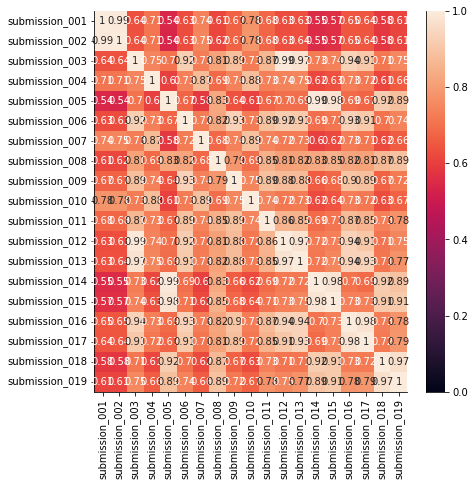

In [14]:
fig = plt.figure(figsize=(7., 7.))
sns.heatmap(corr, annot=True, vmin=0., vmax=1.)
sns.despine()